In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

from PIL import Image
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

device

device(type='cuda')

In [3]:
class HorseZebraDataset(Dataset):
    def __init__(self, data_path, direction='h2z', mode='train', transforms=None):
        self.mode = mode
        self.direction = direction
        self.transforms = transforms
        
        self.horse_path = os.path.join(data_path, self.mode, 'horse')
        self.zebra_path = os.path.join(data_path, self.mode, 'zebra')
        self.horses = os.listdir(self.horse_path)
        self.zebras = os.listdir(self.zebra_path)
    
        self.n_horses = len(self.horses)
        self.n_zebras = len(self.zebras)
        self.len_ds = max(self.n_horses, self.n_zebras)
    
    def __len__(self):
        return self.len_ds

    def __getitem__(self, idx):
        horse_file = self.horses[idx % self.n_horses]
        zebra_file = self.zebras[idx % self.n_zebras]
        
        horse = Image.open(os.path.join(self.horse_path, horse_file) ).convert('RGB')
        zebra = Image.open(os.path.join(self.zebra_path, zebra_file) ).convert('RGB')
        
        if self.transforms:
            horse = self.transforms(horse)
            zebra = self.transforms(zebra)

        if self.direction == 'h2z':
            return horse, zebra
        elif self.direction == 'z2h':
            return zebra, horse

In [4]:
PATH = os.path.join(os.getcwd(), 'data', 'horse2zebra')
BATCH_SIZE = 64

preprocessor = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

dataset = HorseZebraDataset(PATH, transforms=preprocessor)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))

In [5]:
def get_mean_std(loader: DataLoader):
    sum, sq_sum = 0., 0.
    
    for data, _ in loader:
        sum += torch.mean(data, dim=[0, 2, 3])
        sq_sum += torch.mean(data ** 2, dim=[0, 2, 3])
    
    mean = sum / len(loader)
    std = (sq_sum / len(loader) - mean ** 2) ** .5
    
    return mean, std

mean, std = get_mean_std(loader)

mean, std

(tensor([0.5001, 0.4911, 0.4329]), tensor([0.2580, 0.2582, 0.2756]))

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = HorseZebraDataset(PATH, mode='train', transforms=train_transforms)
test_ds = HorseZebraDataset(PATH, mode='test', transforms=test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator(device=device))

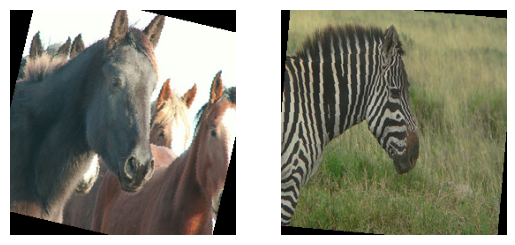

In [7]:
a, b = train_ds[0]
fig, axes = plt.subplots(1, 2)

a, b = a.clone().cpu(), b.clone().cpu()
a, b = to_pil_image(a * std.view(-1, 1, 1) + mean.view(-1, 1, 1)), to_pil_image(b * std.view(-1, 1, 1) + mean.view(-1, 1, 1))

axes[0].imshow(a)
axes[0].axis('off')
axes[1].imshow(b)
axes[1].axis('off')

plt.show()

In [8]:
class GenBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_bn=True, use_act=True, **kwargs):
        super().__init__()
        self.basic_block = nn.Sequential()
        
        if down:
            self.basic_block.add_module('conv', nn.Conv2d(in_channels, out_channels, padding_mode='reflect', **kwargs))
        else:
            self.basic_block.add_module('conv_t', nn.ConvTranspose2d(in_channels, out_channels, **kwargs))
        
        if use_bn:
            self.basic_block.add_module('in', nn.InstanceNorm2d(out_channels))
        
        if use_act:
            self.basic_block.add_module('relu', nn.ReLU(inplace=True))
        else:
            self.basic_block.add_module('identity', nn.Identity())

    def forward(self, x):
        return self.basic_block(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            GenBasicBlock(channels, channels, kernel_size=3, padding=1),
            GenBasicBlock(channels, channels, kernel_size=3, padding=1, use_act=False)
        )
    
    def forward(self, x):
        return x + self.block(x)

In [9]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, n_blocks):
        super().__init__()
        self.encoder = nn.Sequential(
            GenBasicBlock(in_channels, out_channels, use_bn=False, kernel_size=7, padding=3),
            GenBasicBlock(out_channels, out_channels*2, kernel_size=3, stride=2, padding=1),
            GenBasicBlock(out_channels*2, out_channels*4, kernel_size=3, stride=2, padding=1),
        )
        self.res_blocks = nn.Sequential(*[ResidualBlock(out_channels*4) for _ in range(n_blocks)])
        self.decoder = nn.Sequential(
            GenBasicBlock(out_channels*4, out_channels*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            GenBasicBlock(out_channels*2, out_channels, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            GenBasicBlock(out_channels, in_channels, down=False, use_bn=False, kernel_size=7, padding=3)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.decoder(x)

        return torch.tanh(x)

In [10]:
Generator(3, 64, 6)

Generator(
  (encoder): Sequential(
    (0): GenBasicBlock(
      (basic_block): Sequential(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
        (relu): ReLU(inplace=True)
      )
    )
    (1): GenBasicBlock(
      (basic_block): Sequential(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (in): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): ReLU(inplace=True)
      )
    )
    (2): GenBasicBlock(
      (basic_block): Sequential(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (in): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): ReLU(inplace=True)
      )
    )
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): GenBasicBlock(
          (basic_bloc

In [11]:
class DisBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_bn=True, use_act=True, **kwargs):
        super().__init__()
        self.basic_block = nn.Sequential()
        
        self.basic_block.add_module('conv', nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, padding_mode='reflect'))
        
        if use_bn:
            self.basic_block.add_module('in', nn.InstanceNorm2d(out_channels))
        
        if use_act:
            self.basic_block.add_module('leaky_relu', nn.LeakyReLU(.2, inplace=True))
        else:
            self.basic_block.add_module('identity', nn.Identity())
        
    def forward(self, x):
        return self.basic_block(x)

In [12]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super().__init__()
        self.discriminator = nn.Sequential(
            DisBasicBlock(in_channels, 64, use_bn=False),
            DisBasicBlock(64, 128),
            DisBasicBlock(128, 256),
            DisBasicBlock(256, 512),
            DisBasicBlock(512, out_channels, kernel_size=4, stride=1, padding=1),
        )
    
    def forward(self, x):
        return self.discriminator(x)

In [13]:
Discriminator(3)

Discriminator(
  (discriminator): Sequential(
    (0): DisBasicBlock(
      (basic_block): Sequential(
        (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): DisBasicBlock(
      (basic_block): Sequential(
        (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (in): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): DisBasicBlock(
      (basic_block): Sequential(
        (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (in): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (3): DisBasicBlock(
     

In [14]:
def init_params(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, .2)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
            
gen_a = Generator(3, 256, 6).apply(init_params).to(device)
gen_b = Generator(3, 256, 6).apply(init_params).to(device)
disc_a = Discriminator(3, 1).apply(init_params).to(device)
disc_b = Discriminator(3, 1).apply(init_params).to(device)

opt_gen = optim.Adam(list(gen_a.parameters()) + list(gen_b.parameters()), lr=1e-5, betas=(.5, .999))
opt_disc = optim.Adam(list(disc_a.parameters()) + list(disc_b.parameters()), lr=1e-5, betas=(.5, .999))

g_scaler = torch.cuda.amp.grad_scaler.GradScaler()
d_scaler = torch.cuda.amp.grad_scaler.GradScaler()

l1 = nn.L1Loss()
mse = nn.MSELoss()

CYCLE_WEIGHT = 10
IDENTITY_WEIGHT = 2

In [15]:
def train(gen_a, gen_b, disc_a, disc_b, opt_gen: optim.Optimizer, opt_disc: optim.Optimizer, g_scaler: torch.cuda.amp.grad_scaler.GradScaler, d_scaler: torch.cuda.amp.grad_scaler.GradScaler, l1, mse, loader, epochs):
    for epoch in range(epochs):
        for idx, (a, b) in enumerate(loader):
            a, b = a.to(device), b.to(device)

            # Discriminator
            with torch.cuda.amp.autocast_mode.autocast():
                fake_a = gen_a(b) # 가짜 a
                d_a_real = disc_a(a) # 진짜 a에 대해 판단
                d_a_fake = disc_a(fake_a.detach()) # 가짜 a에 대해 판단
                d_a_real_loss = mse(d_a_real, torch.ones_like(d_a_real))
                d_a_fake_loss = mse(d_a_fake, torch.zeros_like(d_a_fake))
                d_a_loss = d_a_real_loss + d_a_fake_loss
                
                fake_b = gen_b(a)
                d_b_real = disc_b(b)
                d_b_fake = disc_b(fake_b.detach())
                d_b_real_loss = mse(d_b_real, torch.ones_like(d_b_real))
                d_b_fake_loss = mse(d_b_fake, torch.zeros_like(d_b_fake))
                d_b_loss = d_b_real_loss + d_b_fake_loss
                
                d_loss = (d_a_loss + d_b_loss) / 2
            
            opt_disc.zero_grad()
            d_scaler.scale(d_loss).backward()
            d_scaler.step(opt_disc)
            d_scaler.update()
            
            # Generator
            with torch.cuda.amp.autocast_mode.autocast():
                d_a_fake = disc_a(fake_a) # 가짜 a에 대한 판단
                d_b_fake = disc_b(fake_b) # 가자 b에 대한 판단
                g_a_loss = mse(d_a_fake, torch.ones_like(d_a_fake))
                g_b_loss = mse(d_b_fake, torch.ones_like(d_b_fake))

                cycle_a = gen_a(fake_b)
                cycle_b = gen_b(fake_a)
                cycle_a_loss = l1(a, cycle_a)
                cycle_b_loss = l1(b, cycle_b)

                identity_a = gen_a(a)
                identity_b = gen_b(b)
                identity_a_loss = l1(a, identity_a)
                identity_b_loss = l1(b, identity_b)
            
                g_loss =g_a_loss + g_b_loss + CYCLE_WEIGHT*(cycle_a_loss + cycle_b_loss) + IDENTITY_WEIGHT*(identity_a_loss + identity_b_loss)
            
            opt_gen.zero_grad()
            g_scaler.scale(g_loss).backward()
            g_scaler.step(opt_gen)               
            g_scaler.update()
        
        print(f'Epoch: {epoch + 1}, G_Loss: {g_loss.item():.6f}, D_loss: {d_loss.item():.6f}, idx: {idx + 1}')

In [16]:
train(gen_a, gen_b, disc_a, disc_b, opt_gen, opt_disc, g_scaler, d_scaler, l1, mse, train_loader, 500)

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacty of 8.00 GiB of which 0 bytes is free. Of the allocated memory 21.59 GiB is allocated by PyTorch, and 675.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF